In [92]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D, MaxPool2D, Softmax, Activation,Dropout,Flatten,Input
from keras.layers import BatchNormalization,Activation,AveragePooling2D,LayerNormalization
from keras.activations import relu
from keras import Model
from keras import backend as K

import random
import numpy as np
import os

import warnings 

import matplotlib.pyplot as plt

from keras.datasets import mnist



In [93]:
warnings.simplefilter('ignore')
os.close(2)
os.open(os.devnull, os.O_RDWR)

2

In [94]:
def fix_random_seed(seed=42):
    
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Fixer la seed pour Keras (backend TensorFlow)
    K.clear_session()
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    tf.compat.v1.set_random_seed(seed)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    os.environ['PYTHONHASHSEED'] = str(seed)

# Preparing dataset for training et evalution

In [95]:
class CustomDataset(keras.utils.Sequence):
    def __init__(self,batch_size,num_classes,data,labels,shuffle=False):
        
        self.batch_size=batch_size
        self.num_classes=num_classes
        self.shuffle=shuffle
        self.data = data.astype('float32')/255 # Normalisation
        self.labels = keras.utils.to_categorical(labels, self.num_classes)
        self.indexes=np.arange(len(self.data))

        if self.shuffle:
            np.random.shuffle(self.indexes)
        
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indexes = self.indexes[start:end]  # Récupérer les indices mélangés pour ce lot
        batch_x = self.data[batch_indexes]  # Récupérer les images selon les indices mélangés
        batch_y = self.labels[batch_indexes]  # Récupérer les étiquettes selon les indices mélangés
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)




### Hyperparameters and data loadding 

In [96]:

num_classes = 10
epochs = 10
batch_size = 128
img_rows, img_cols = 28, 28
fix_random_seed(seed=42)

# This will be use for training and evaluting the a convnet model that will build below
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_data=CustomDataset(batch_size,num_classes,train_images,train_labels,shuffle=True)
val_data=CustomDataset(batch_size,num_classes,test_images,test_labels,shuffle=True)

# This will be use for training and evaluting the a MLPs model that will build below
(xtrain,ytrain),(xtest,ytest)=mnist.load_data()
xtrain=xtrain.reshape(xtrain.shape[0],xtrain.shape[1]*xtrain.shape[2]) # an 28x28 image is transform into a vector of size 784=28*28
xtest=xtest.reshape(xtest.shape[0],xtest.shape[1]*xtest.shape[2])
train_data1=CustomDataset(batch_size,num_classes,xtrain,ytrain,shuffle=True)
val_data1=CustomDataset(batch_size,num_classes,xtest,ytest,shuffle=True)


### Data visualization

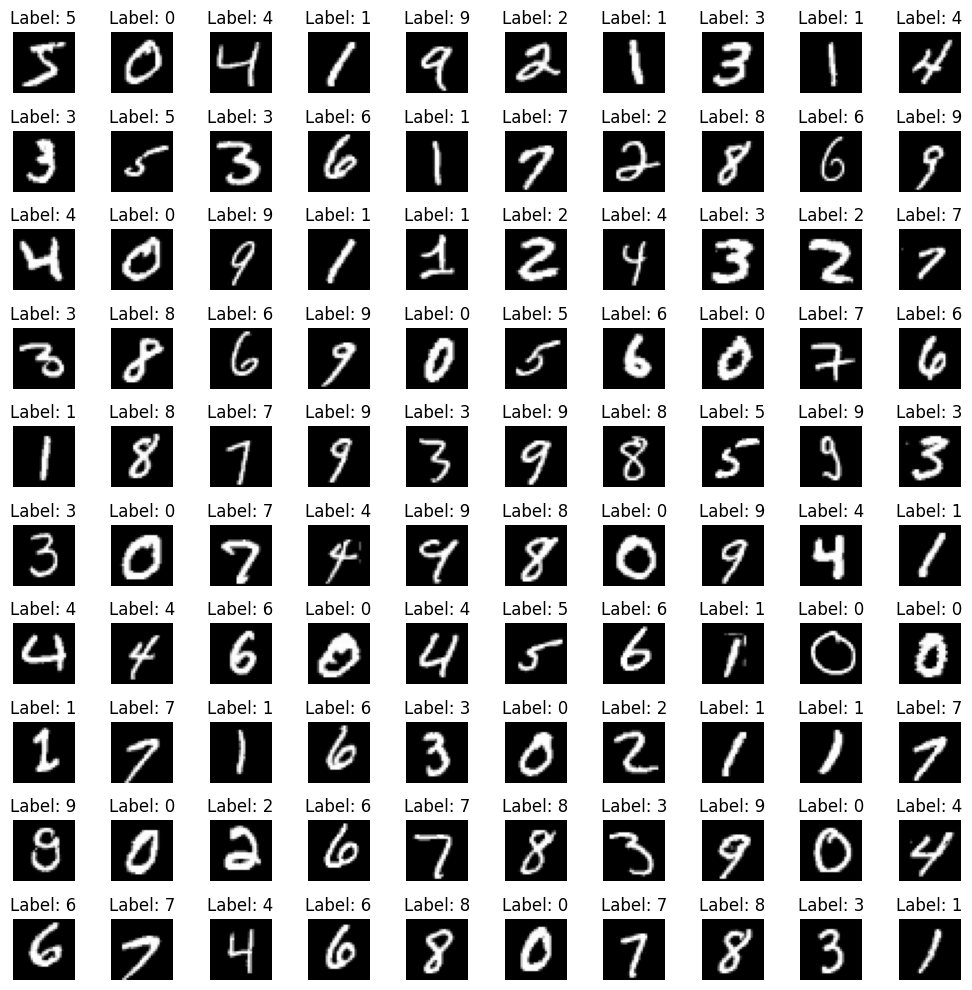

In [97]:

num_rows = 10
num_cols = 10


plt.figure(figsize=(10, 10))
for i in range(num_rows * num_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f'Label: {train_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Building sequential Model

In [98]:
def build_sequential_model():
    dense_model=Sequential()
    dense_model.add(Dense(256,input_shape=(784,)))
    dense_model.add(LayerNormalization())
    dense_model.add(Dense(units=256,activation='relu'))
    dense_model.add(LayerNormalization())
    dense_model.add(Dropout(0.3))
    dense_model.add(Dense(units=10,activation='softmax'))
    
    return dense_model.build()

# Building Muli-Layers Perceptrons Model using POO

In [99]:
class MyMLPs(keras.Model):
    def __init__(self):
        super(MyMLPs,self).__init__()
        self.fc1=Dense(256)
        self.ln1=LayerNormalization()
        self.fc2=Dense(units=256,activation='relu')
        self.ln2=LayerNormalization()
        self.dropout=Dropout(0.3)
        self.fc3=Dense(units=10,activation='softmax')


    def call(self,input):
        x=self.fc1(input)
        x=self.ln1(x)
        x=self.fc2(x)
        x=self.ln2(x)
        x=self.dropout(x)
        x=self.fc3(x)
        return x


### My MLPs model initialization, training and evalution

In [100]:

input_layer = Input(shape=(784,))
x=MyMLPs()(input_layer)

model=Model(inputs=input_layer,outputs=x)
dense_model.fit(train_data1,epochs=20,verbose=1,validation_data=val_data1)
# Évaluer le modèle
score = dense_model.evaluate(val_data1, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0182 - accuracy: 0.9937 - val_loss: 0.0780 - val_accuracy: 0.9835
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0183 - accuracy: 0.9937 - val_loss: 0.0789 - val_accuracy: 0.9813
Epoch 3/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0175 - accuracy: 0.9937 - val_loss: 0.0913 - val_accuracy: 0.9788
Epoch 4/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0181 - accuracy: 0.9935 - val_loss: 0.0814 - val_accuracy: 0.9811
Epoch 5/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0162 - accuracy: 0.9946 - val_loss: 0.0815 - val_accuracy: 0.9814
Epoch 6/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0164 - accuracy: 0.9947 - val_loss: 0.0770 - val_accuracy: 0.9818
Epoch 7/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0177 - accuracy: 0.9940 - val_loss: 0.0813 - val_accuracy: 0.9806
Epoch 

# Building convolutional neural network from scratch

In [101]:
class MyConvnet(keras.Model):
    def __init__(self):
        super(MyConvnet,self).__init__()
        #self.input=Input(input_shape[0],input_shape[1],input_shape[2])
        self.conv1=Conv2D(filters=64,kernel_size=(3,3),padding='same',strides=1)
        self.batchN1=BatchNormalization()
        self.relu1=relu
        self.maxpool1=MaxPool2D(pool_size=(2,2),strides=2)
        self.conv2=Conv2D(filters=128,kernel_size=(3,3),padding='same',strides=1)
        self.batchN2=BatchNormalization()
        self.relu2=relu
        self.conv3=Conv2D(filters=128,kernel_size=(3,3),padding='same',strides=1)
        self.batchN3=BatchNormalization()
        self.relu3=relu
        self.flatten=Flatten()
        self.fc2=Dense(units=256,activation='relu')
        self.dropout=Dropout(0.2)
        self.fc3=Dense(units=10,activation='softmax')


    def call(self,input):
        x=self.conv1(input)
        x=self.batchN1(x)
        x=self.relu1(x)
        x=self.maxpool1(x)
        x=self.conv2(x)
        x=self.batchN2(x)
        x=self.relu2(x)
        x=self.conv3(x)
        x=self.batchN3(x)
        x=self.relu3(x)
        x=self.dropout(x)
        x=self.flatten(x)
        x=self.fc2(x)
        x=self.dropout(x)
        x=self.fc3(x)
        return x

### My convnet model initialization

In [102]:

input_layer=Input(shape=(28,28,1))
#gpu_device = tf.config.list_physical_devices('GPU')[0]
#tf.config.experimental.set_memory_growth(gpu_device, True)

#with tf.device('/GPU:0'):
x=MyConvnet()(input_layer)
model=Model(inputs=input_layer,outputs=x)
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics='accuracy')
#print(model.summary(expand_nested=True))



### Model training and evalution

In [103]:
#Train model
fix_random_seed(seed=42)
model.fit(train_data,epochs=epochs,verbose=1,validation_data=val_data)
# Évaluer le modèle
score = model.evaluate(val_data, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



Epoch 1/10
469/469 [==============================] - 7s 13ms/step - loss: 0.2160 - accuracy: 0.9345 - val_loss: 0.3569 - val_accuracy: 0.9155
Epoch 2/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0729 - accuracy: 0.9787 - val_loss: 0.0451 - val_accuracy: 0.9859
Epoch 3/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0511 - accuracy: 0.9845 - val_loss: 0.0337 - val_accuracy: 0.9873
Epoch 4/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0408 - accuracy: 0.9876 - val_loss: 0.0336 - val_accuracy: 0.9883
Epoch 5/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0328 - accuracy: 0.9900 - val_loss: 0.0301 - val_accuracy: 0.9897
Epoch 6/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0280 - accuracy: 0.9914 - val_loss: 0.0297 - val_accuracy: 0.9887
Epoch 7/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0245 - accuracy: 0.9928 - val_loss: 0.0255 - val_accuracy: 0.9907